# WIP Notebook

# Imports

## Libraries

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Standard Library Imports
import datetime
import glob
import io
import re
import warnings
import zipfile

# Third-Party Imports
import branca.colormap as cm
import folium
import geopandas as gpd
import holidays
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pyod
from pyod.models.xgbod import IForest
import requests
import seaborn as sns
import shapely
from shapely import wkb
from shapely.geometry import Point

from scipy.stats import kurtosis, mode, pearsonr, skew, t
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skrub import TableVectorizer

# Importing custom libraries
from wip_lib import date_encoder

## Data

### Provided data

In [70]:
# Import provided data
train = pd.read_parquet("/Users/pierrehaas/bike_counters/data/train.parquet")
test = pd.read_parquet("/Users/pierrehaas/bike_counters/data/final_test.parquet")

### External data

#### Weather data

In [112]:
# Import additionally sourced data

# https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/
weather = pd.read_csv(
    "/Users/pierrehaas/bike_counters/external_data/weather/H_75_previous-2020-2022.csv.gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

#### Velib data

In [149]:
# api_url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/velib-disponibilite-en-temps-reel/exports/json"

# # Retrieve data from the API
# response = requests.get(api_url)
# response_data = response.json()

# pd.DataFrame(response_data).sort_values(["duedate"])

,stationcode,name,is_installed,capacity,numdocksavailable,numbikesavailable,mechanical,ebike,is_renting,is_returning,duedate,coordonnees_geo,nom_arrondissement_communes,code_insee_commune
1154,18010,Riquet - Marx Dormoy,NON,26,26,0,0,0,NON,NON,2018-01-11T18:46:20+00:00,"{'lon': 2.3601756244898, 'lat': 48.89021003702}",Paris,75056
559,15063,Convention - Saint-Charles,NON,23,11,10,5,5,NON,NON,2018-02-19T01:05:15+00:00,"{'lon': 2.2831090539694, 'lat': 48.843156111116}",Paris,75056
341,42207,Place des Marseillais,OUI,37,37,0,0,0,NON,NON,2018-03-16T14:13:06+00:00,"{'lon': 2.4059280753135686, 'lat': 48.82663907...",Charenton-le-Pont,94018
889,20015,Bagnolet - Orteaux,OUI,0,0,0,0,0,NON,NON,2018-05-25T08:09:58+00:00,"{'lon': 2.3984125256538396, 'lat': 48.85708641...",Paris,75056
855,8116,Champs-Elysees - Bassano,OUI,25,25,0,0,0,NON,NON,2021-02-21T19:09:18+00:00,"{'lon': 2.300238981843, 'lat': 48.871811807816}",Paris,75056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,21019,Edouard Vaillant - Paul-Adolphe Souriau,OUI,28,6,22,20,2,OUI,OUI,2024-12-10T13:23:27+00:00,"{'lon': 2.2479459643364, 'lat': 48.834845858829}",Boulogne-Billancourt,92012
1262,17050,Batignolles - Abel Truchet,OUI,28,25,2,0,2,OUI,OUI,2024-12-10T13:23:27+00:00,"{'lon': 2.3238347490884, 'lat': 48.883103904582}",Paris,75056
51,13118,Regnault - Patay,OUI,63,12,51,41,10,OUI,OUI,2024-12-10T13:23:27+00:00,"{'lon': 2.377065159380436, 'lat': 48.824357822...",Paris,75056
378,6030,Assas - Vaugirard,OUI,35,4,31,19,12,OUI,OUI,2024-12-10T13:23:27+00:00,"{'lon': 2.3292413726449, 'lat': 48.848274111398}",Paris,75056


#### Public transport data

In [85]:
# https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/information/
# URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e6bcf4c994951fc086e31db6819a3448/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e35b9ec0a183a8f2c7a8537dd43b124c/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rf-202\d/202\d_S\d+_NB_FER\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(f, sep="\t", parse_dates=["JOUR"], dayfirst=True)
                    dfs.append(df)

# Combine all DataFrames
underground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


# # https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/information/
# # URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/41adcbd4216382c232ced4ccbf60187e/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/68cac32e8717f476905a60006a4dca26/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rs-202\d/202\d_T\d+_NB_SURFACE\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(
                        f,
                        sep="\t",
                        parse_dates=["JOUR"],
                        dayfirst=True,
                        encoding="latin1",
                    )
                    dfs.append(df)

# Combine all DataFrames
overground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

#### Car traffic data

In [6]:
# URLs of the zip files
urls = [
    "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2020_zip/",
    # "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2021_zip/", # This file's compression format is broken, thus I provide a download link below
    "https://www.dropbox.com/scl/fi/sfqzlzpyxcf4yied3yucc/comptage-routier-2021.zip?rlkey=6k6hr3kywl8tvm4ax1qv2nv88&st=ktehiium&dl=1",
]

# Initialize an empty list to store DataFrames
dfs = []

# Process each ZIP file
for i, url in enumerate(urls):
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Process every file in the archive
            for file in z.namelist():
                # Skip directories and __MACOSX files
                if file.endswith("/") or "__MACOSX" in file:
                    continue
                # For the second URL, ensure files are within "comptage-routier-2021" directory
                if i == 1 and not file.startswith("comptage-routier-2021/"):
                    continue
                with z.open(file) as f:
                    # Assuming the files are semicolon-separated and have a "t_1h" column
                    df = pd.read_csv(f, sep=";", parse_dates=["t_1h"])
                    dfs.append(df)

# Combine all DataFrames
cars_count = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

#### Construction sites

In [176]:
# https://opendata.paris.fr/explore/dataset/chantiers-a-paris-copie0/information/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
construction_sites_2020 = pd.read_parquet(
    "/Users/pierrehaas/bike_counters/external_data/construction_sites/chantiers-a-paris-2020.parquet"
)

# https://opendata.paris.fr/explore/embed/dataset/chantiers-a-paris-copie1/table/?disjunctive.cp_arrondissement&disjunctive.chantier_categorie&disjunctive.moa_principal&disjunctive.chantier_synthese&disjunctive.localisation_detail&disjunctive.localisation_stationnement
construction_sites_2021 = pd.read_parquet(
    "/Users/pierrehaas/bike_counters/external_data/construction_sites/chantiers-a-paris-2021.parquet"
)

#### Multimodal vehicle traffic data

In [6]:
# https://parisdata.opendatasoft.com/explore/dataset/comptage-multimodal-comptages/information/?disjunctive.label&disjunctive.mode&disjunctive.voie&disjunctive.sens&disjunctive.trajectoire&sort=-t&basemap=jawg.dark&location=13,48.87023,2.34614
multimodal_traffic = pd.read_parquet(
    "/Users/pierrehaas/bike_counters/external_data/multimodal_traffic/comptage-multimodal-comptages.parquet"
)

# EDA

## Exploring train and test sets

### Basic exploration

In [71]:
train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [72]:
train.shape

(496827, 12)

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [74]:
train.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

In [75]:
train["date"].min(), train["date"].max()

(Timestamp('2020-09-01 01:00:00'), Timestamp('2021-09-09 23:00:00'))

In [76]:
test.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [77]:
test.shape

(51440, 10)

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 51440 non-null  category      
 1   counter_name               51440 non-null  category      
 2   site_id                    51440 non-null  int64         
 3   site_name                  51440 non-null  category      
 4   date                       51440 non-null  datetime64[us]
 5   counter_installation_date  51440 non-null  datetime64[us]
 6   coordinates                51440 non-null  category      
 7   counter_technical_id       51440 non-null  category      
 8   latitude                   51440 non-null  float64       
 9   longitude                  51440 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(2), int64(1)
memory usage: 2.2 MB


In [79]:
test.nunique()

counter_id                    56
counter_name                  56
site_id                       30
site_name                     30
date                         933
counter_installation_date     22
coordinates                   30
counter_technical_id          30
latitude                      30
longitude                     30
dtype: int64

In [80]:
test["date"].min(), test["date"].max()

(Timestamp('2021-09-10 01:00:00'), Timestamp('2021-10-18 21:00:00'))

Checking installation dates

In [81]:
train["counter_installation_date"].unique()

<DatetimeArray>
['2013-01-18 00:00:00', '2017-07-12 00:00:00', '2017-12-15 00:00:00',
 '2018-06-27 00:00:00', '2018-11-29 00:00:00', '2018-11-30 00:00:00',
 '2018-11-28 00:00:00', '2018-12-07 00:00:00', '2019-09-04 00:00:00',
 '2019-11-06 00:00:00', '2019-11-08 00:00:00', '2019-11-07 00:00:00',
 '2019-11-01 00:00:00', '2019-12-12 00:00:00', '2019-11-14 00:00:00',
 '2019-11-05 00:00:00', '2019-12-11 00:00:00', '2019-12-10 00:00:00',
 '2020-02-18 00:00:00', '2020-02-11 00:00:00', '2020-07-22 00:00:00',
 '2020-11-29 00:00:00']
Length: 22, dtype: datetime64[us]

### Exploring bike count through time and location

#### Mapping of bike count by counter location

In [82]:
# Calculate the total bike count per location
location_counts = (
    train.groupby(["latitude", "longitude"])["bike_count"].sum().reset_index()
)

# Create a colormap
colormap = cm.linear.PuRd_09.scale(
    location_counts["bike_count"].min(), location_counts["bike_count"].max()
)

# Create the map
m = folium.Map(
    location=train[["latitude", "longitude"]].mean(axis=0).values, zoom_start=13
)

# Add markers to the map
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=colormap(row["bike_count"]),
        fill=True,
        fill_color="black",  # Fill center with black
        fill_opacity=1,  # Ensure the fill is opaque
        popup=f"Bike Count: {row['bike_count']}",
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

m

It seems that the further away from the city center, the less bike passage there is. Let's try to find a smart way of creating a new feature that represents this.

In [83]:
(
    train.groupby("site_name", observed=True)["bike_count"]
    .sum()
    .sort_values(ascending=False)
).head()

site_name
Totem 73 boulevard de Sébastopol    3490139.0
Totem 64 Rue de Rivoli              2567605.0
Face au 48 quai de la marne         1718564.0
27 quai de la Tournelle             1613233.0
Quai d'Orsay                        1567932.0
Name: bike_count, dtype: float64

The counter with most bikes registered is: Totem 73 boulevard de Sébastopol. Let's use the coordinates from this site to create a distance feature.

#### Creating new distance feature

In [84]:
lat_long_center = (
    train[["latitude", "longitude"]]
    - mode(
        train[train["site_name"] == "Totem 73 boulevard de Sébastopol"][
            ["latitude", "longitude"]
        ]
    )[0]
)

# We calculate the distance the previously identified site to all others
# We call the result the distance to the center since the station is close to the center of Paris
dist_center = np.linalg.norm(
    lat_long_center,
    axis=1,
)

In [85]:
print(
    f"Correlation coefficient (Distance to station with most counts VS. Log bike count): {pearsonr(dist_center, train["log_bike_count"])[0]:.3f}"
)

Correlation coefficient (Distance to station with most counts VS. Log bike count): -0.213


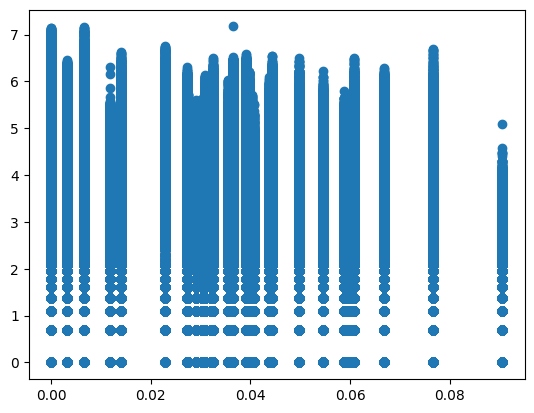

In [86]:
plt.scatter(dist_center, train["log_bike_count"])
plt.show()

In [87]:
train["distance_to_center"] = dist_center

We repeat the same process for the test set.

In [88]:
lat_long_center = (
    test[["latitude", "longitude"]]
    - mode(
        test[test["site_name"] == "Totem 73 boulevard de Sébastopol"][
            ["latitude", "longitude"]
        ]
    )[0]
)

test["distance_to_center"] = np.linalg.norm(
    lat_long_center,
    axis=1,
)

#### Creating clusters of sites

In [89]:
# Group by counter_name and calculate the mean log_bike_count
grouped_train = (
    train.groupby("counter_name", observed=True)["log_bike_count"].mean().reset_index()
)

# Reshape the data for clustering
X = grouped_train[["log_bike_count"]]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
grouped_train["cluster"] = kmeans.fit_predict(X)

# Sort clusters by mean log_bike_count and reassign cluster labels
sorted_clusters = (
    grouped_train.groupby("cluster")["log_bike_count"].mean().sort_values().index
)
cluster_mapping = {
    old_label: new_label for new_label, old_label in enumerate(sorted_clusters)
}
grouped_train["cluster"] = grouped_train["cluster"].map(cluster_mapping)

# Merge the cluster labels back to the original DataFrame
train = train.merge(
    grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
)
test = test.merge(
    grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
)

#### Time series of bike count by location

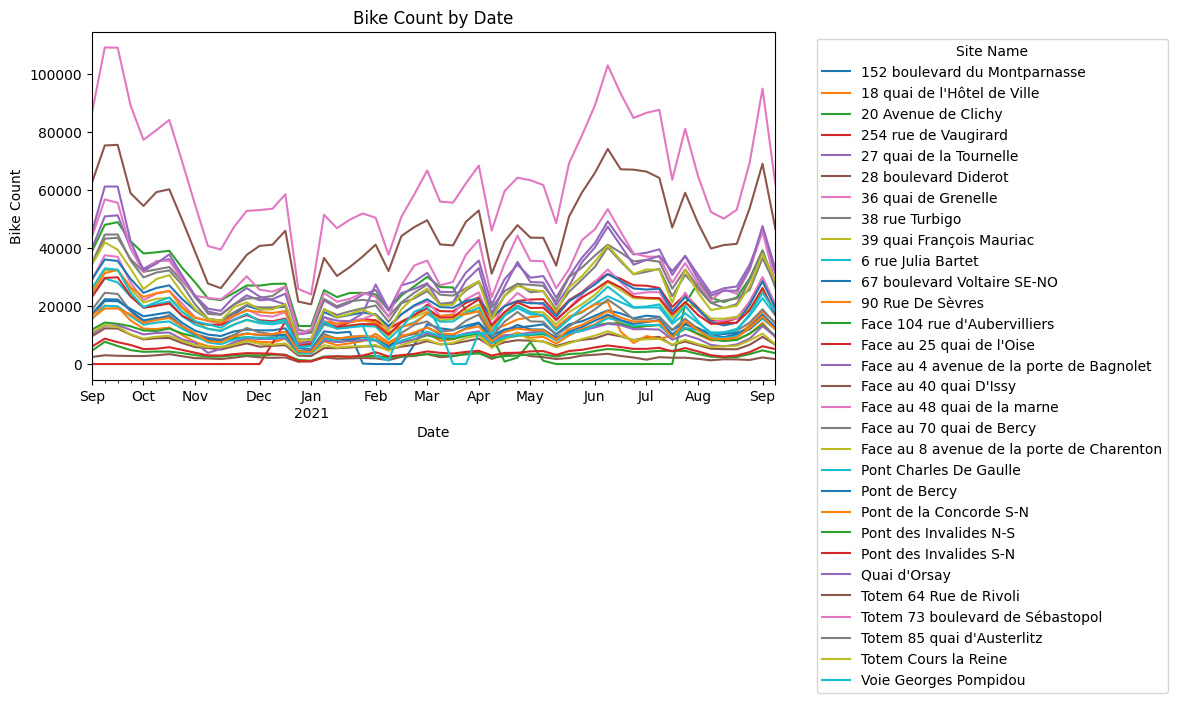

In [90]:
# Pivot the DataFrame so each counter name has its own column
pivot_df = (
    train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)[
        "bike_count"
    ]
    .sum()
    .unstack()
)

# Plot the data
pivot_df.plot(figsize=(12, 6))
plt.title("Bike Count by Date")
plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.legend(title="Site Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Distribution of bike count by location

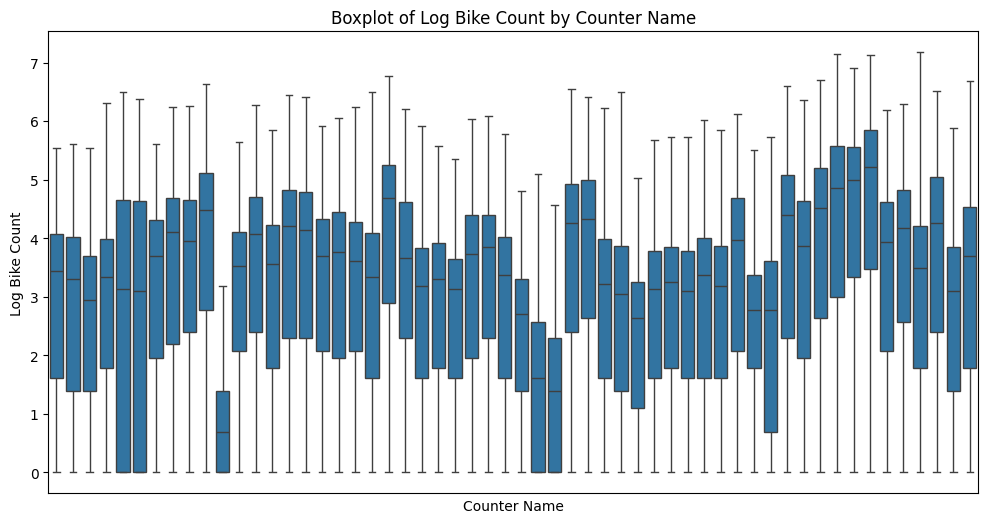

In [91]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="counter_name", y="log_bike_count", data=train)

# Add labels and title
plt.xlabel("Counter Name")
plt.ylabel("Log Bike Count")
plt.title("Boxplot of Log Bike Count by Counter Name")

# Hide the x-axis labels
plt.xticks([])

# Display the plot
plt.show()

#### Weekly bike count table by location

In [92]:
train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)[
    "bike_count"
].sum().unstack()

site_name,152 boulevard du Montparnasse,18 quai de l'Hôtel de Ville,20 Avenue de Clichy,254 rue de Vaugirard,27 quai de la Tournelle,28 boulevard Diderot,36 quai de Grenelle,38 rue Turbigo,39 quai François Mauriac,6 rue Julia Bartet,...,Pont de Bercy,Pont de la Concorde S-N,Pont des Invalides N-S,Pont des Invalides S-N,Quai d'Orsay,Totem 64 Rue de Rivoli,Totem 73 boulevard de Sébastopol,Totem 85 quai d'Austerlitz,Totem Cours la Reine,Voie Georges Pompidou
date,,,,,,,,,,,,,,,,,,,,,
2020-09-06,16902.0,16949.0,38803.0,0.0,39748.0,9572.0,28939.0,34467.0,24648.0,23439.0,...,17276.0,15838.0,4595.0,6025.0,45437.0,62498.0,86444.0,34680.0,34209.0,26040.0
2020-09-13,21747.0,20168.0,48004.0,0.0,50907.0,12302.0,37516.0,43241.0,32397.0,29486.0,...,22330.0,19129.0,7677.0,8760.0,61196.0,75367.0,109156.0,44624.0,41960.0,32981.0
2020-09-20,21680.0,19715.0,48918.0,0.0,51277.0,12263.0,36962.0,43527.0,32247.0,28158.0,...,22262.0,19166.0,6206.0,7540.0,61213.0,75565.0,109069.0,44684.0,39417.0,32518.0
2020-09-27,19022.0,15031.0,42328.0,0.0,39875.0,10115.0,28095.0,36188.0,25884.0,23289.0,...,18420.0,17120.0,4803.0,6576.0,42319.0,58893.0,89158.0,35701.0,32874.0,24633.0
2020-10-04,16460.0,12214.0,38126.0,0.0,32840.0,8501.0,21993.0,31801.0,21217.0,19755.0,...,15070.0,14184.0,4215.0,5172.0,32221.0,54521.0,77298.0,29868.0,25860.0,19585.0
2020-10-11,17137.0,12076.0,38531.0,0.0,35326.0,8895.0,24264.0,32600.0,22492.0,20561.0,...,15891.0,15161.0,4301.0,5296.0,34650.0,59283.0,80661.0,31556.0,29292.0,21346.0
2020-10-18,17861.0,12578.0,39050.0,0.0,36143.0,8975.0,25212.0,33459.0,22792.0,21604.0,...,16145.0,15874.0,4311.0,5819.0,37807.0,60252.0,84167.0,32266.0,30680.0,22956.0
2020-10-25,14192.0,10016.0,33158.0,0.0,29804.0,7225.0,20873.0,28640.0,19286.0,16522.0,...,13038.0,12975.0,3764.0,4878.0,30541.0,49679.0,69739.0,27329.0,24459.0,17983.0
2020-11-01,11520.0,7609.0,28183.0,0.0,23024.0,5842.0,16093.0,23501.0,14861.0,13595.0,...,10304.0,10553.0,3086.0,3903.0,23563.0,38720.0,54942.0,20587.0,18931.0,14750.0


It seems like some sites are not capturing any data at all at times (multiple weeks sometimes). We will need to investigate this further.

Let's take a specific site that did not capture bikes for multiple weeks.

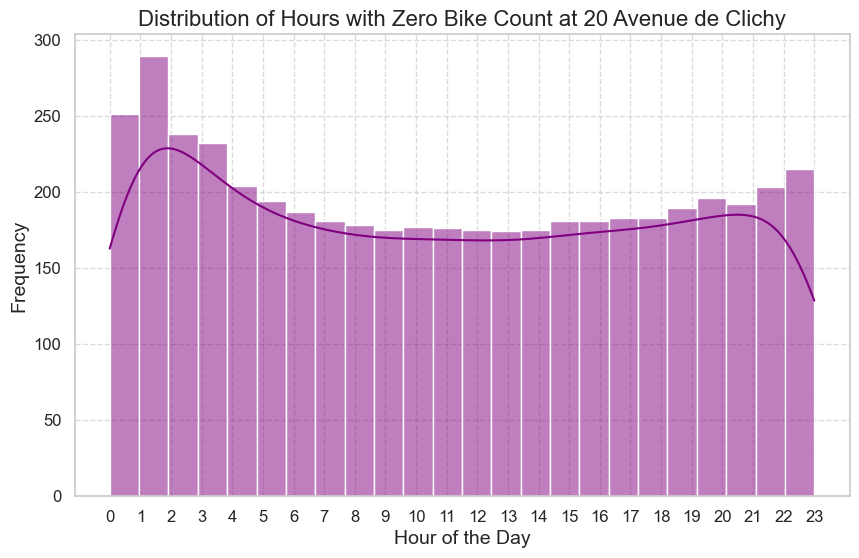

In [93]:
# Set the style
sns.set(style="whitegrid")

# Filter the data
filtered_data = train[
    (train["site_name"] == "20 Avenue de Clichy") & (train["bike_count"] == 0)
]["date"].dt.hour

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, bins=24, kde=True, color="purple")

# Add titles and labels
plt.title(
    "Distribution of Hours with Zero Bike Count at 20 Avenue de Clichy", fontsize=16
)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Customize the ticks
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()

We should try to find information about sites under repair (or else) to improve our model and make sure it predicts 0 bike_count when the site cannot capture data.

Let's check if there are changes to some variables (e.g., change in counter id) when the bike count is 0 for a prolonged period.

In [94]:
train[
    (train["date"] >= "2021-05-09")
    & (train["date"] <= "2021-07-25")
    & (train["site_name"] == "20 Avenue de Clichy")
].groupby("counter_name", observed=True).nunique()

,counter_id,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,distance_to_center,cluster
counter_name,,,,,,,,,,,,,
20 Avenue de Clichy NO-SE,1,1,1,80,1849,1,1,1,1,1,80,1,1
20 Avenue de Clichy SE-NO,1,1,1,69,1849,1,1,1,1,1,69,1,1


There does not seem to be a pattern of change in any variable when the bike count is 0 for a prolonged period.

### Encoding dates for further analyses

In [95]:
train_encoded, test_encoded = date_encoder(train), date_encoder(test)

In [96]:
train_encoded.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,year,quarter,month,day,weekday,hour,hour_scaled,is_weekend,is_bank_holiday,is_school_holiday
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2020,3,9,1,2,2,8.660254e-01,0,0,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2020,3,9,1,2,3,7.071068e-01,0,0,0
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2020,3,9,1,2,4,5.000000e-01,0,0,0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2020,3,9,1,2,15,-7.071068e-01,0,0,0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2020,3,9,1,2,18,-1.836970e-16,0,0,0


In [97]:
test_encoded.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,year,quarter,month,day,weekday,hour,hour_scaled,is_weekend,is_bank_holiday,is_school_holiday
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,2021,3,9,10,5,1,0.965926,0,0,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,2021,3,9,10,5,13,-0.965926,0,0,0
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,2021,3,9,10,5,17,-0.258819,0,0,0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,2021,3,9,10,5,19,0.258819,0,0,0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,2021,3,9,10,5,22,0.866025,0,0,0


### Analyzing impact of date features on bike count

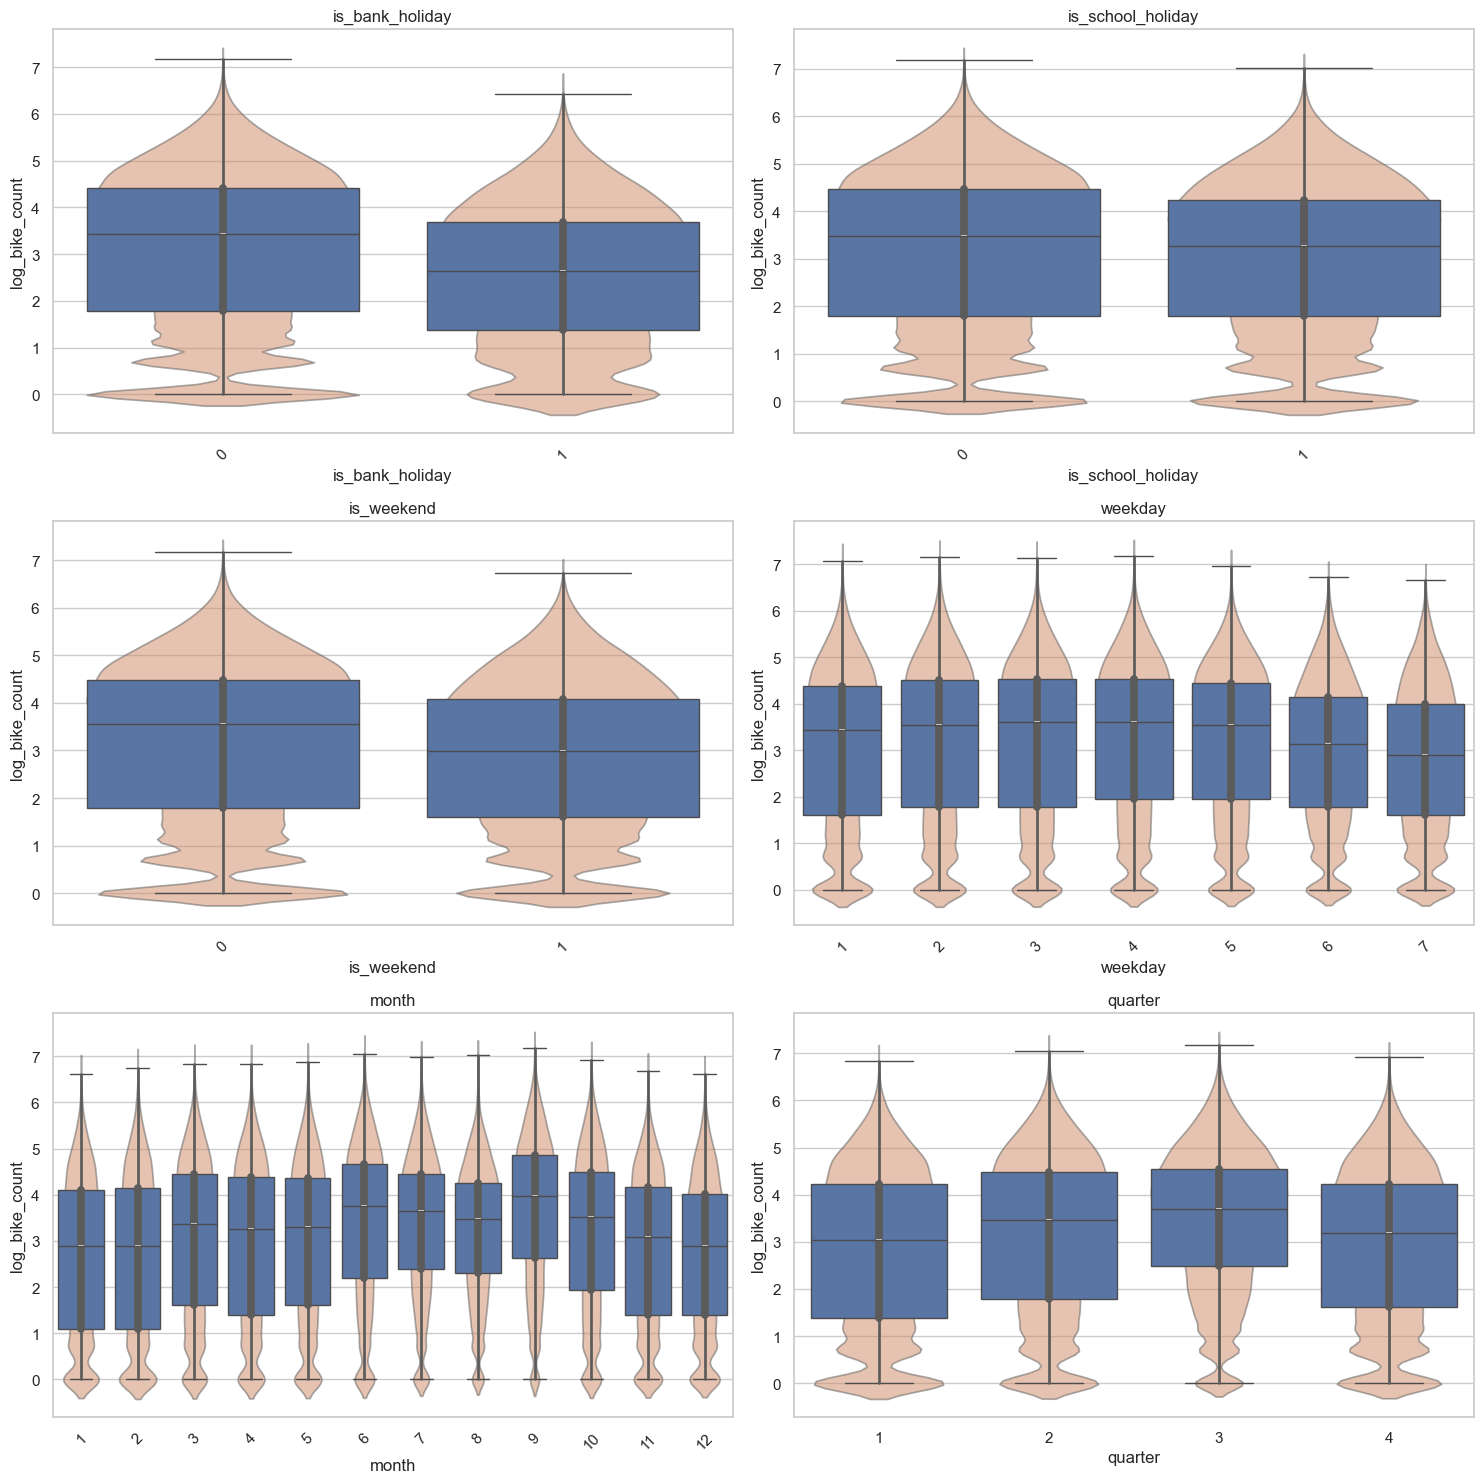

In [98]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot for 'is_bank_holiday'
sns.boxplot(
    ax=axes[0, 0], x=train_encoded["is_bank_holiday"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[0, 0].artists, alpha=0.5)
sns.violinplot(
    ax=axes[0, 0], x=train_encoded["is_bank_holiday"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[0, 0].collections, alpha=0.5)
axes[0, 0].set_title("is_bank_holiday")
axes[0, 0].tick_params(axis="x", rotation=45)

# Plot for 'is_school_holiday'
sns.boxplot(
    ax=axes[0, 1],
    x=train_encoded["is_school_holiday"],
    y=train_encoded["log_bike_count"],
)
plt.setp(axes[0, 1].artists, alpha=0.5)
sns.violinplot(
    ax=axes[0, 1],
    x=train_encoded["is_school_holiday"],
    y=train_encoded["log_bike_count"],
)
plt.setp(axes[0, 1].collections, alpha=0.5)
axes[0, 1].set_title("is_school_holiday")
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot for 'is_weekend'
sns.boxplot(
    ax=axes[1, 0], x=train_encoded["is_weekend"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[1, 0].artists, alpha=0.5)
sns.violinplot(
    ax=axes[1, 0], x=train_encoded["is_weekend"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[1, 0].collections, alpha=0.5)
axes[1, 0].set_title("is_weekend")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot for 'weekday'
sns.boxplot(
    ax=axes[1, 1], x=train_encoded["weekday"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[1, 1].artists, alpha=0.5)
sns.violinplot(
    ax=axes[1, 1], x=train_encoded["weekday"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[1, 1].collections, alpha=0.5)
axes[1, 1].set_title("weekday")
axes[1, 1].tick_params(axis="x", rotation=45)

# Plot for 'month'
sns.boxplot(ax=axes[2, 0], x=train_encoded["month"], y=train_encoded["log_bike_count"])
plt.setp(axes[2, 0].artists, alpha=0.5)
sns.violinplot(
    ax=axes[2, 0], x=train_encoded["month"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[2, 0].collections, alpha=0.5)
axes[2, 0].set_title("month")
axes[2, 0].tick_params(axis="x", rotation=45)

# Plot for 'quarter'
sns.boxplot(
    ax=axes[2, 1], x=train_encoded["quarter"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[2, 1].artists, alpha=0.5)
sns.violinplot(
    ax=axes[2, 1], x=train_encoded["quarter"], y=train_encoded["log_bike_count"]
)
plt.setp(axes[2, 1].collections, alpha=0.5)
axes[2, 1].set_title("quarter")

plt.tight_layout()
plt.show()

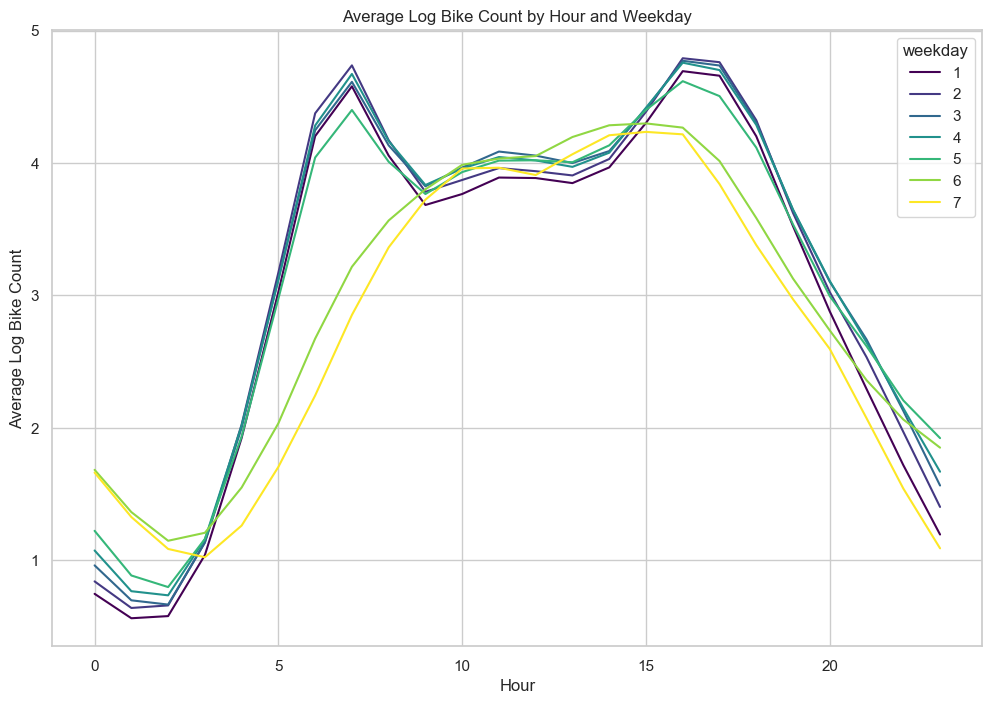

In [99]:
# Create the plot
plot = (
    train_encoded.groupby(["hour", "weekday"])["log_bike_count"]
    .mean()
    .unstack()
    .plot(
        figsize=(12, 8),  # Increase the figure size
        colormap="viridis",  # Use a colormap
        title="Average Log Bike Count by Hour and Weekday",  # Add a title
    )
)

# Add labels
plot.set_xlabel("Hour")
plot.set_ylabel("Average Log Bike Count")
plot.set_title("Average Log Bike Count by Hour and Weekday")

# Add grid
plt.grid(True)

# Show the plot
plt.show()

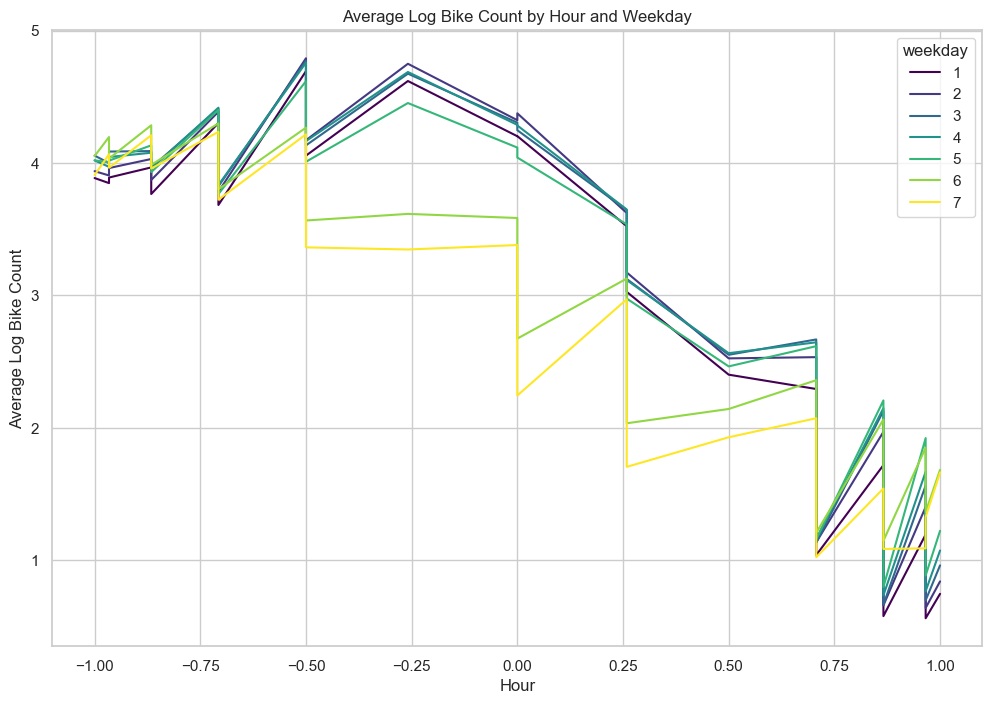

In [100]:
# Create the plot
plot = (
    train_encoded.groupby(["hour_scaled", "weekday"])["log_bike_count"]
    .mean()
    .unstack()
    .plot(
        figsize=(12, 8),  # Increase the figure size
        colormap="viridis",  # Use a colormap
        title="Average Log Bike Count by Hour and Weekday",  # Add a title
    )
)

# Add labels
plot.set_xlabel("Hour")
plot.set_ylabel("Average Log Bike Count")
plot.set_title("Average Log Bike Count by Hour and Weekday")

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## Weather data

### Basic exploration

In [ ]:
weather.head()

In [ ]:
weather.shape

In [ ]:
weather.info()

In [ ]:
weather["date"].min(), weather["date"].max()

In [ ]:
weather[["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI"]].nunique()

In [ ]:
weather.groupby("NUM_POSTE")["NOM_USUEL"].first()

Check the number of weather stations in the dataset.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(weather.groupby("date")["NOM_USUEL"].count(), linestyle="-")
plt.title("Number of data collection stations per Date")
plt.xlabel("Date")
plt.ylabel("Count of NOM_USUEL")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

Now, let's have a look at the location of these weather stations.

In [ ]:
# Calculate the total count per location
location_counts = (
    weather.groupby(["LAT", "LON", "NUM_POSTE"]).size().reset_index(name="count")
)

# Create the map
m = folium.Map(location=weather[["LAT", "LON"]].mean(axis=0).values, zoom_start=13)

# Add markers to the map
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row["LAT"], row["LON"]],
        radius=5,
        color="black",
        fill=True,
        fill_color="black",
        fill_opacity=1,
        popup=f"NUM_POSTE: {row['NUM_POSTE']}<br>Count: {row['count']}",
    ).add_to(m)

m

In our view, there are two potential approaches to merging the weather data with the train and test sets:

* Match the weather data to the train and test sets based on the closest weather station to the coordinates.
* Match the weather data to the train and test sets using the average weather information from all collection stations in Paris.

Let's check for missing values in the weather data. We shall drop the "NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI" columns since they are categorical (or just a marker of the specific data collection station).

In [ ]:
weather.drop(
    columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "date"]
).isna().sum()

There seem to be fields with no values at all. We shall drop these fields and continue a more detailed on the remaining fields.

In [ ]:
weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "date"]).dropna(
    axis=1, how="all"
).isna().sum()

We just went from 198 to 91 columns.

Since there are a lot of missing values in the weather data, we will start by check if there are collection stations that have more missing values than others.

In [ ]:
missing_values_per_num_poste = (
    weather.drop(columns=["NOM_USUEL", "LAT", "LON", "ALTI", "date"])
    .dropna(axis=1, how="all")
    .groupby("NUM_POSTE")
    .apply(lambda x: x.isna().sum(), include_groups=False)
)
missing_values_per_num_poste.sum(axis=1)

Maybe we should use the 75114001 station only, or just average out the values from all stations.

 Now, let's compute the average measure of each weather feature for each date in Paris as a whole (average out the measure over all stations at a given point in time).

In [ ]:
(
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI"])
    .dropna(axis=1, how="all")
    .groupby("date")
    .mean()
    .isna()
    .sum()
    .sort_values()
)

"QDXI3S" seems to have many missing values. We shall exclude it from the analysis. Now, let's check the remaining fields for missing values.

In [ ]:
(
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .isna()
    .sum()
    .sort_values()
    != 0
).sum()

There are 12 fields with missing values. We shall fill these missing values with linear interpolation since there are very few missing values. This is for sake of simplicity.

In [174]:
weather_reduced = (
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .interpolate(method="linear")
)

### Augmenting weather data with feature engineering

In [ ]:
weather_reduced.head()

In [176]:
weather_reduced["is_rain"] = (weather_reduced["RR1"] > 0).astype(int)

weather_reduced["q_rain_lag_1h"] = weather_reduced["RR1"].shift(1)
weather_reduced["t_rain_lag_1h"] = weather_reduced["DRR1"].shift(1)
weather_reduced["is_rain_lag_1h"] = weather_reduced["is_rain"].shift(1)

weather_reduced["q_rain_next_1h"] = weather_reduced["RR1"].shift(-1)
weather_reduced["t_rain_next_1h"] = weather_reduced["DRR1"].shift(-1)
weather_reduced["is_rain_next_1h"] = weather_reduced["is_rain"].shift(-1)

weather_reduced["temp_lag_1h"] = weather_reduced["T"].shift(1)
weather_reduced["temp_next_1h"] = weather_reduced["T"].shift(-1)

weather_reduced["max_temp"] = weather_reduced.groupby(weather_reduced.index.date)[
    "T"
].transform("max")
weather_reduced["will_rain"] = (
    weather_reduced.groupby(weather_reduced.index.date)["RR1"]
    .transform(lambda x: (x > 0).any())
    .astype(int)
)

### Exploring weather relationship with bike count

In [177]:
weather_eda = (
    train_encoded[["date", "counter_id", "log_bike_count"]]
    .merge(weather_reduced, left_on="date", right_on="date", how="left")
    .set_index(["date", "counter_id"])
)

#### Correlation heatmap, uncovering linear relationships

In [178]:
# Calculate the correlation matrix
correlation_matrix = weather_eda.corr()

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 14))

# Draw the heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
)

# Set the title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

In [ ]:
threshold = 0.1

high_corr_features = correlation_matrix[
    np.abs(correlation_matrix["log_bike_count"]) > threshold
].index.values.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix[np.abs(correlation_matrix["log_bike_count"]) > threshold][
        high_corr_features
    ],
    annot=False,
    cmap="coolwarm",
)

# Set the title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

#### Exploring relationships of selected features with log_bike_count

In [181]:
weather_features = [
    "RR1",
    "DRR1",
    "T",
    "TNSOL",
    "TCHAUSSEE",
    "U",
    "GLO",
    "is_rain",
    "q_rain_lag_1h",
    "t_rain_lag_1h",
    "is_rain_lag_1h",
    "q_rain_next_1h",
    "t_rain_next_1h",
    "is_rain_next_1h",
    "temp_lag_1h",
    "temp_next_1h",
    "max_temp",
    "will_rain",
]

In [182]:
weather_eda = (
    train_encoded[["log_bike_count", "date", "hour", "weekday", "counter_id"]]
    .merge(
        weather_reduced[weather_features], left_on="date", right_on="date", how="left"
    )
    .set_index(["date", "counter_id"])
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for 'is_rain'
sns.boxplot(ax=ax, x=weather_eda["is_rain"], y=weather_eda["log_bike_count"])
plt.setp(ax.artists, alpha=0.5)
sns.violinplot(ax=ax, x=weather_eda["is_rain"], y=weather_eda["log_bike_count"])
plt.setp(ax.collections, alpha=0.5)
ax.set_title("is_rain")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of weekdays
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# Plot each weekday
for i, weekday in enumerate(range(1, 8)):
    ax = axes[i]
    sns.boxplot(
        ax=ax,
        x=weather_eda["is_rain"],
        y=weather_eda["log_bike_count"],
        data=weather_eda[weather_eda["weekday"] == weekday],
    )
    plt.setp(ax.artists, alpha=0.5)
    sns.violinplot(
        ax=ax,
        x=weather_eda["is_rain"],
        y=weather_eda["log_bike_count"],
        data=weather_eda[weather_eda["weekday"] == weekday],
    )
    plt.setp(ax.collections, alpha=0.5)
    ax.set_title(weekdays[i])
    ax.tick_params(axis="x", rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot for is_rain = 0
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 0],
    x="weekday",
    y="log_bike_count",
    label="No Rain",
)

# Plot for is_rain = 1
sns.lineplot(
    data=weather_eda[weather_eda["is_rain"] == 1],
    x="weekday",
    y="log_bike_count",
    label="Rain",
)

# Add labels and title
plt.xlabel("Weekday")
plt.ylabel("Log Bike Count")
plt.title("Log Bike Count by Day and Rain Condition")
plt.legend(title="Rain Condition")

# Show the plot
plt.show()

In [ ]:
# Number of features
num_features = len(weather_features)

# Calculate the number of rows and columns for subplots
nrows = (num_features + 1) // 2
ncols = 2

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(weather_features):
    axes[i].scatter(weather_eda[feature], weather_eda["log_bike_count"])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Log Bike Count")
    axes[i].set_title(f"{feature} vs Log Bike Count")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = weather_eda.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
)

# Set the title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

### Reducing dimensionality of weather data

In [189]:
weather_features = [
    "RR1",
    "DRR1",
    "T",
    "TNSOL",
    "TCHAUSSEE",
    "U",
    "GLO",
    # "is_rain",
    "q_rain_lag_1h",
    "t_rain_lag_1h",
    # "is_rain_lag_1h",
    "q_rain_next_1h",
    "t_rain_next_1h",
    # "is_rain_next_1h",
    "temp_lag_1h",
    "temp_next_1h",
    "max_temp",
    # "will_rain",
]

In [191]:
mask = (weather_reduced.index >= train["date"].min()) & (
    weather_reduced.index <= test["date"].max()
)

In [ ]:
# Perform PCA with the maximum number of components
pca = PCA()
pca.fit(weather_reduced[mask][weather_features])

# Calculate the cumulative explained variance ratio
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
    color="b",
)
plt.title("Explained Variance by Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
n = 5

pca = PCA(n_components=n)

X_pca1 = pca.fit_transform(weather_reduced[mask][weather_features])

weather_pca = pd.DataFrame(
    X_pca1,
    index=weather_reduced[mask][weather_features].index,
    columns=["weather_" + str(i) for i in range(1, n + 1)],
).reset_index()

print(
    f"% of data variance explained by reduced PCA with {n} components: {pca.explained_variance_ratio_.sum():.3f}"
)

In [ ]:
weather_pca.head()

### Merging weather data with train and test sets

We propose to ways of merging the weather data with the train and test sets:

* Merge handpicked weather features with the train and test sets.

In [70]:
# train_encoded = train_encoded.merge(
#     weather_reduced[weather_features],
#     left_on="date",
#     right_index=True,
#     how="left",
# )

# test_encoded = test_encoded.merge(
#     weather_reduced[weather_features],
#     left_on="date",
#     right_index=True,
#     how="left",
# )

* Merge the PCA-transformed weather data with the train and test sets.

In [71]:
train_encoded = train_encoded.merge(
    weather_pca,
    on="date",
    how="left",
)

test_encoded = test_encoded.merge(
    weather_pca,
    on="date",
    how="left",
)

## Velib data

## Public transport data

### Basic exploration

Let's compute the total number of commuters per day in Ile-de-France.

In [ ]:
daily_underground_transport = underground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_underground_transport

In [ ]:
daily_overground_transport = overground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_overground_transport

In [ ]:
# Calculate daily totals
daily_underground_transport = underground_transport.groupby("JOUR")["NB_VALD"].sum()
daily_overground_transport = overground_transport.groupby("JOUR")["NB_VALD"].sum()

# Resample to weekly totals
weekly_underground_transport = daily_underground_transport.resample("W").sum()
weekly_overground_transport = daily_overground_transport.resample("W").sum()

# Plot daily totals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(daily_underground_transport, label="Underground")
plt.plot(daily_overground_transport, label="Overground")
plt.plot(daily_underground_transport + daily_overground_transport, label="Total")
plt.legend()
plt.title("Daily Transport Totals")

# Plot weekly totals
plt.subplot(2, 1, 2)
plt.plot(weekly_underground_transport, label="Underground")
plt.plot(weekly_overground_transport, label="Overground")
plt.plot(weekly_underground_transport + weekly_overground_transport, label="Total")
plt.legend()
plt.title("Weekly Transport Totals")

plt.tight_layout()
plt.show()

Let's combine the daily number of commuters of both overground and underground transport and encode the dates to push further analysis.

In [75]:
daily_transport = (
    daily_underground_transport + daily_overground_transport
).reset_index()

daily_transport = date_encoder(daily_transport, col="JOUR")[
    (daily_transport["JOUR"] >= "2020-09-01")
    & (daily_transport["JOUR"] <= "2021-10-18")
]

In [ ]:
daily_transport.head()

Using this new data, we will try to detect days of strikes in the public transport system.

### Outlier detection

In [ ]:
plt.hist(daily_transport["NB_VALD"])
plt.show()

In [ ]:
# Create a fancy boxplot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot boxplot for 'NB_VALD'
sns.boxplot(ax=ax, y=daily_transport["NB_VALD"])
plt.setp(ax.artists, alpha=0.5)

# Optionally, add a violin plot for additional visualization
sns.violinplot(ax=ax, y=daily_transport["NB_VALD"])
plt.setp(ax.collections, alpha=0.5)

ax.set_title("Boxplot of NB_VALD", fontsize=16)
ax.set_xlabel("NB_VALD", fontsize=14)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Create a fancy boxplot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot boxplot for 'NB_VALD'
sns.boxplot(ax=ax, y=daily_transport["NB_VALD"])
plt.setp(ax.artists, alpha=0.5)

# Optionally, add a violin plot for additional visualization
sns.violinplot(ax=ax, y=daily_transport["NB_VALD"])
plt.setp(ax.collections, alpha=0.5)

ax.set_title("Boxplot of NB_VALD", fontsize=16)
ax.set_xlabel("NB_VALD", fontsize=14)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
avg_daily_transport = daily_transport["NB_VALD"].mean()
std_daily_transport = daily_transport["NB_VALD"].std()
mask = (daily_transport["NB_VALD"] < avg_daily_transport - 2 * std_daily_transport) | (
    daily_transport["NB_VALD"] > avg_daily_transport + 2 * std_daily_transport
)

daily_transport[mask]

### Merging public transport data with train and test sets

In [81]:
train_encoded = train_encoded.merge(
    daily_transport[["year", "month", "day", "NB_VALD"]],
    left_on=["year", "month", "day"],
    right_on=["year", "month", "day"],
    how="left",
)

test_encoded = test_encoded.merge(
    daily_transport[["year", "month", "day", "NB_VALD"]],
    left_on=["year", "month", "day"],
    right_on=["year", "month", "day"],
    how="left",
)

## Car traffic data

### Basic exploration

In [ ]:
cars_count.head()

In [ ]:
cars_count.shape

In [ ]:
hourly_cars_count = (
    cars_count[
        (cars_count["t_1h"] >= train["date"].min() - datetime.timedelta(hours=1))
        & (cars_count["t_1h"] <= test["date"].max() + datetime.timedelta(hours=1))
    ]
    .groupby("t_1h")["q"]
    .sum()
    .reset_index()
)

hourly_cars_count

In [ ]:
# Group by day and calculate the cumulative sum of 'q' for each day
hourly_cars_count["daily_cumsum"] = hourly_cars_count.groupby(
    hourly_cars_count["t_1h"].dt.to_period("d")
)["q"].cumsum()
hourly_cars_count.head()

In [ ]:
# Group by week and sum the car counts for each week
weekly_sum = (
    cars_count.groupby(cars_count["t_1h"].dt.to_period("W"))["q"].sum().reset_index()
)

# Convert the period to datetime for plotting
weekly_sum["t_1h"] = weekly_sum["t_1h"].dt.start_time

# Plot the weekly average number of cars
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, x=weekly_sum["t_1h"], y=weekly_sum["q"], marker="o")
ax.set_title("Weekly Average Number of Cars", fontsize=16)
ax.set_xlabel("Week", fontsize=14)
ax.set_ylabel("Average Number of Cars", fontsize=14)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Merging car traffic data with train and test sets

In [86]:
train_encoded = train_encoded.merge(
    hourly_cars_count, left_on="date", right_on="t_1h", how="left"
)
test_encoded = test_encoded.merge(
    hourly_cars_count, left_on="date", right_on="t_1h", how="left"
)

## Construction sites

### Basic exploration

In [ ]:
construction_sites_2020.head()

In [ ]:
construction_sites_2020.shape

In [ ]:
construction_sites_2021.head()

In [ ]:
construction_sites_2021.shape

In [355]:
construction_sites = pd.concat(
    [construction_sites_2020, construction_sites_2021], axis=0
)

In [ ]:
construction_sites.head()

In [ ]:
construction_sites.shape

In [ ]:
construction_sites.info()

In [ ]:
construction_sites[
    [
        "num_emprise",
        "moa_principal",
        "demande_cite_id",
        "chantier_cite_id",
        "geo_shape",
        "geo_point_2d",
    ]
].nunique()

### Encoding dates to datetime

In [360]:
# construction_sites["date_debut"] = pd.to_datetime(
#     construction_sites["date_debut"], format="%Y-%m-%d"
# )

# construction_sites["date_fin"] = pd.to_datetime(
#     construction_sites["date_fin"], format="%Y-%m-%d"
# )

In [361]:
# construction_sites.info()

### Deleting duplicate construction sites and sites with no location information

Let's try to understand the data better by checking observations with duplicated chantier_cite_id.

In [ ]:
construction_sites[
    construction_sites["chantier_cite_id"].duplicated(keep=False)
].sort_values("chantier_cite_id").head()

It seems that the duplicated observations are not exactly the same. Looking at the first two observations, we can see that, although the chantier_cite_id are the same for the two, the observtions have different areas. We shall keep the two observations, and for that matter any other duplicated observation under the same scenario, and only drop duplicated observations that have the exact same information (it implies that the construction started in 2020 or before and ended in 2021 or after | observations were both in the 2020 and 2021 datasets).

In [363]:
construction_sites = construction_sites.drop_duplicates().dropna(
    subset=["geo_shape", "geo_point_2d"]
)

In [ ]:
construction_sites.shape

In [ ]:
has_duplicates = construction_sites.duplicated(keep=False).any()
print(f"Are there duplicates? {has_duplicates}")

In [ ]:
num_duplicates = construction_sites.duplicated(keep=False).sum()
print(f"Number of duplicated rows: {num_duplicates}")

### Selecting relevant construction sites

Let's take a look at the types of construction sites in the dataset.

In [ ]:
construction_sites["localisation_detail"].unique()

It seems like there is a special encoding for construction sites that are located ob bike lanes (PISTE_CYCLABLE). We shall take a look at these observations specifically.

In [368]:
# construction_sites_simplified = construction_sites[
#     ~construction_sites["localisation_detail"].isin(
#         [
#             "EMPRISE_CHAUSSEE",
#             "EMPRISE_TROTTOIR",
#             "EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",
#             None,
#         ]
#     )
# ]


# construction_sites_simplified["localisation_detail"].unique()

We drop irrelevant columns.

In [ ]:
cs_reduced = construction_sites.drop(
    columns=[
        "moa_principal",
        "demande_cite_id",
        "chantier_synthese",
        "localisation_stationnement",
        "chantier_cite_id",
        "chantier_categorie",
        "cp_arrondissement",
        "surface",
        "localisation_detail",
    ]
)

cs_reduced.head()

### Visualizing construction sites shape

In [ ]:
geo_point_wkb = cs_reduced["geo_shape"].iloc[0]
geometry = wkb.loads(geo_point_wkb)
print(geometry)

In [ ]:
# Extract x and y coordinates for plotting
x, y = geometry.exterior.xy

# Plot the polygon
plt.plot(x, y)
plt.title("Polygon Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Transforming geoshapes to coordinates

In [372]:
cs_reduced[["geo_shape", "geo_point_2d"]] = cs_reduced[
    ["geo_shape", "geo_point_2d"]
].apply(lambda x: shapely.wkb.loads(x))

In [ ]:
null_count = cs_reduced["geo_shape"].isnull().sum()
if null_count > 0:
    print(f"There are {null_count} null geometries.")
else:
    print("No null geometries found.")

In [ ]:
null_count = cs_reduced["geo_point_2d"].isnull().sum()
if null_count > 0:
    print(f"There are {null_count} null geometries.")
else:
    print("No null geometries found.")

In [375]:
gdf = gpd.GeoDataFrame(cs_reduced, geometry="geo_shape", crs="EPSG:4326")

In [376]:
# gdf.explore("area", legend=False)

### Finding if bike counters fall within construction sites

In [377]:
latitude_combined = pd.concat(
    [train_encoded["latitude"], test_encoded["latitude"]], ignore_index=True
)
longitude_combined = pd.concat(
    [train_encoded["longitude"], test_encoded["longitude"]], ignore_index=True
)
coords = list(
    zip(
        latitude_combined,
        longitude_combined,
    )
)

index1 = pd.concat([train_encoded["date"], test_encoded["date"]], ignore_index=True)
index2 = pd.concat(
    [train_encoded["counter_id"], test_encoded["counter_id"]], ignore_index=True
)

points_gdf = gpd.GeoDataFrame(
    coords,
    index=[index1, index2],
    columns=["longitude", "latitude"],
    geometry=[Point(xy) for xy in coords],
    crs=gdf.crs,  # Make sure this matches the gdf of construction sites
)

points_gdf.head()

In [380]:
# spatial join with predicate='within' to see which points lie inside a polygon
joined = gpd.sjoin(points_gdf, gdf, how="left", predicate="within")

joined.head()

In [ ]:
print(
    f"Number of bike counters that fall (at some point) in a construction site: {joined.shape[0] - joined["num_emprise"].isna().sum()}"
)

There are no bike counters that fall within construction sites. Thus, the construction site dataset will not be useful for our analysis.

## Multimodal traffic data

### Basic exploration

In [15]:
multimodal_traffic.head()

,id_trajectoire,id_site,label,t,mode,nb_usagers,voie,sens,trajectoire,coordonnees_geo
0,10004_1 -> 1,10004,[Paris] Rivoli x Nicolas Flamel,2024-11-14 01:00:00+01:00,"Véhicules légers < 3,5t",1,Piste cyclable,O-E,1 -> 1,b'\x01\x01\x00\x00\x00\x03\xea\xcd\xa8\xf9\xca...
1,10004_5 -> 3,10004,[Paris] Rivoli x Nicolas Flamel,2024-11-14 02:00:00+01:00,"Véhicules légers < 3,5t",166,Voie de circulation générale,E-O,5 -> 3,b'\x01\x01\x00\x00\x00\x03\xea\xcd\xa8\xf9\xca...
2,10004_5 -> 3,10004,[Paris] Rivoli x Nicolas Flamel,2024-11-14 05:00:00+01:00,"Véhicules légers < 3,5t",80,Voie de circulation générale,E-O,5 -> 3,b'\x01\x01\x00\x00\x00\x03\xea\xcd\xa8\xf9\xca...
3,10004_5 -> 3,10004,[Paris] Rivoli x Nicolas Flamel,2024-11-14 06:00:00+01:00,"Véhicules légers < 3,5t",101,Voie de circulation générale,E-O,5 -> 3,b'\x01\x01\x00\x00\x00\x03\xea\xcd\xa8\xf9\xca...
4,10004_5 -> 2,10004,[Paris] Rivoli x Nicolas Flamel,2024-11-14 07:00:00+01:00,Autobus et autocars,1,Coronapiste,E-O,5 -> 2,b'\x01\x01\x00\x00\x00\x03\xea\xcd\xa8\xf9\xca...


In [16]:
multimodal_traffic.shape

(3220687, 10)

In [17]:
multimodal_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220687 entries, 0 to 3220686
Data columns (total 10 columns):
 #   Column           Dtype                       
---  ------           -----                       
 0   id_trajectoire   object                      
 1   id_site          object                      
 2   label            object                      
 3   t                datetime64[ms, Europe/Paris]
 4   mode             object                      
 5   nb_usagers       int64                       
 6   voie             object                      
 7   sens             object                      
 8   trajectoire      object                      
 9   coordonnees_geo  object                      
dtypes: datetime64[ms, Europe/Paris](1), int64(1), object(8)
memory usage: 245.7+ MB


In [18]:
multimodal_traffic["t"].min(), multimodal_traffic["t"].max()

(Timestamp('2020-05-23 00:00:00+0200', tz='Europe/Paris'),
 Timestamp('2024-12-08 23:00:00+0100', tz='Europe/Paris'))

In [19]:
multimodal_traffic["date"] = multimodal_traffic["t"].dt.tz_localize(None)

In [20]:
multimodal_traffic["date"].min(), multimodal_traffic["date"].max()

(Timestamp('2020-05-23 00:00:00'), Timestamp('2024-12-08 23:00:00'))

In [21]:
multimodal_traffic["mode"].unique()

array(['Véhicules légers < 3,5t', 'Autobus et autocars', 'Vélos',
       'Véhicules lourds > 3,5t', 'Trottinettes', '2 roues motorisées',
       'Trottinettes + vélos', 'van'], dtype=object)

In [22]:
multimodal_traffic.isna().sum()

id_trajectoire          0
id_site                 0
label              400636
t                       0
mode                    0
nb_usagers              0
voie               400636
sens               400636
trajectoire             0
coordonnees_geo    400636
date                    0
dtype: int64

### Extracting new features

In [23]:
# Remove bike count to avoid feeding the model with the target variable
mask = (multimodal_traffic["mode"] == "Trottinettes + vélos") | (
    multimodal_traffic["mode"] == "Vélos"
)

In [24]:
hourly_vehicle_count = (
    multimodal_traffic[~mask].groupby(["date", "mode"])["nb_usagers"].sum().unstack()
)

In [25]:
hourly_vehicle_count.head()

mode,2 roues motorisées,Autobus et autocars,Trottinettes,"Véhicules lourds > 3,5t","Véhicules légers < 3,5t",van
date,,,,,,
2020-05-23 00:00:00,NaN,5.0,NaN,NaN,85.0,NaN
2020-05-23 01:00:00,NaN,NaN,NaN,NaN,86.0,NaN
2020-05-23 02:00:00,NaN,NaN,NaN,NaN,42.0,NaN
2020-05-23 03:00:00,NaN,NaN,NaN,NaN,46.0,NaN
2020-05-23 04:00:00,NaN,NaN,NaN,1.0,25.0,NaN


In [26]:
hourly_vehicle_count.shift(1)

mode,2 roues motorisées,Autobus et autocars,Trottinettes,"Véhicules lourds > 3,5t","Véhicules légers < 3,5t",van
date,,,,,,
2020-05-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-23 01:00:00,NaN,5.0,NaN,NaN,85.0,NaN
2020-05-23 02:00:00,NaN,NaN,NaN,NaN,86.0,NaN
2020-05-23 03:00:00,NaN,NaN,NaN,NaN,42.0,NaN
2020-05-23 04:00:00,NaN,NaN,NaN,NaN,46.0,NaN
...,...,...,...,...,...,...
2024-12-08 19:00:00,1459.0,289.0,903.0,123.0,13488.0,367.0
2024-12-08 20:00:00,1545.0,323.0,810.0,104.0,13123.0,402.0
2024-12-08 21:00:00,1442.0,297.0,622.0,126.0,12193.0,354.0


In [128]:
hourly_vehicle_count.shape

(37731, 6)

In [129]:
hourly_vehicle_count.isna().sum()

mode
2 roues motorisées           305
Autobus et autocars          737
Trottinettes                2818
Véhicules lourds > 3,5t     1090
Véhicules légers < 3,5t        2
van                        37635
dtype: int64

We shall remove "van" since there are nearly no observations with this type of vehicle.

In [130]:
hourly_vehicle_count = hourly_vehicle_count.drop(columns="van")

In [ ]:
# Group by day and calculate the cumulative sum of 'nb_usagers' for each vehicle type every day
hourly_vehicle_count_lag = hourly_vehicle_count.shift(1).rename(
    columns=lambda x: x + "_lag_1h"
)

In [131]:
# Group by day and calculate the cumulative sum of 'nb_usagers' for each vehicle type every day
daily_cumsum_vh_type = (
    hourly_vehicle_count.groupby(hourly_vehicle_count.index.date)
    .cumsum()
    .rename(columns=lambda x: x + "_cumsum")
)

In [132]:
hourly_direction_count = (
    multimodal_traffic[~mask].groupby(["date", "sens"])["nb_usagers"].sum().unstack()
)

In [133]:
hourly_direction_count.head()

sens,E-O,N-S,NE-SO,O-E,S-N,SO-NE
date,,,,,,
2020-05-23 00:00:00,90.0,NaN,NaN,NaN,NaN,NaN
2020-05-23 01:00:00,86.0,NaN,NaN,NaN,NaN,NaN
2020-05-23 02:00:00,42.0,NaN,NaN,NaN,NaN,NaN
2020-05-23 03:00:00,46.0,NaN,NaN,NaN,NaN,NaN
2020-05-23 04:00:00,26.0,NaN,NaN,NaN,NaN,NaN


In [134]:
hourly_direction_count.shape

(37635, 6)

In [135]:
hourly_direction_count.isna().sum()

sens
E-O         32
N-S       1687
NE-SO    11844
O-E       2209
S-N       7126
SO-NE     7571
dtype: int64

There are quite a lot of missing data points in the dataset. Let's disregard direction.

In [ ]:
hourly_trajectoire_count = (
    multimodal_traffic[~mask]
    .groupby(["date", "trajectoire"])["nb_usagers"]
    .sum()
    .unstack()
)

In [ ]:
hourly_trajectoire_count.head()

In [ ]:
hourly_trajectoire_count.shape

In [ ]:
hourly_trajectoire_count.isna().sum()

Same for trajectoire, too many missing values.

In [139]:
new_multimodal_traffic_features = pd.concat(
    [
        hourly_vehicle_count,
        hourly_vehicle_count_lag,
        daily_cumsum_vh_type,
    ],
    axis=1,
).reset_index()

### Merging multimodal traffic data with train and test sets

In [155]:
train_encoded.merge(
    new_multimodal_traffic_features, on="date", how="left"
).isna().sum().sort_values(ascending=False).head(10)

Trottinettes                      22612
Trottinettes_cumsum               22612
Véhicules lourds > 3,5t_cumsum    15312
Véhicules lourds > 3,5t           15312
Autobus et autocars               15068
Autobus et autocars_cumsum        15068
2 roues motorisées_cumsum          1512
2 roues motorisées                 1512
Véhicules légers < 3,5t_cumsum     1350
Véhicules légers < 3,5t            1350
dtype: int64

Given there was no missing observations in the multimodal traffic data for the nb_usagers column, it means no vehicle of the given type passed through the counter. We shall fill these missing values with 0.

In [142]:
test_encoded.merge(
    new_multimodal_traffic_features, on="date", how="left"
).isna().sum().sort_values(ascending=False).head(10)

counter_id                        0
counter_name                      0
Véhicules lourds > 3,5t_cumsum    0
Trottinettes_cumsum               0
Autobus et autocars_cumsum        0
2 roues motorisées_cumsum         0
Véhicules légers < 3,5t           0
Véhicules lourds > 3,5t           0
Trottinettes                      0
Autobus et autocars               0
dtype: int64

# Detecting outliers and potential strikes in public transport data

## Underground transport

### Using z-score

#### At station level

In [ ]:
ut_grouped = (
    underground_transport.groupby(["JOUR", "CODE_STIF_ARRET"])["NB_VALD"]
    .sum()
    .reset_index()
)
ut_grouped = ut_grouped[
    (ut_grouped["JOUR"] >= "2020-09-01") & (ut_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ut_grouped["JOUR"] = pd.to_datetime(ut_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ut_grouped["day_of_week"] = ut_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean and std) per day_of_week
baseline_stats = (
    ut_grouped.groupby(["CODE_STIF_ARRET", "day_of_week"])["NB_VALD"]
    .agg(["mean", "std"])
    .reset_index()
)
baseline_stats.rename(columns={"mean": "mean_val", "std": "std_val"}, inplace=True)

# Merge the baseline stats back to the original DataFrame
ut_grouped = ut_grouped.merge(
    baseline_stats, on=["CODE_STIF_ARRET", "day_of_week"], how="left"
)

# Compute z-score for each day’s NB_VALD
# Handle cases where std is zero by replacing with a small number
ut_grouped["std_val"] = ut_grouped["std_val"].replace(0, np.nan)
ut_grouped["z_score"] = (ut_grouped["NB_VALD"] - ut_grouped["mean_val"]) / ut_grouped[
    "std_val"
]

# Define an anomaly threshold
# For example, we consider a strike if it's 3 standard deviations below the mean
threshold = -3

# Flag potential strike days
ut_grouped["potential_strike"] = ut_grouped["z_score"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ut_grouped[ut_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[
    ["JOUR", "CODE_STIF_ARRET", "NB_VALD", "z_score", "potential_strike"]
]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

#### At daily level

In [ ]:
ut_grouped = underground_transport.groupby(["JOUR"])["NB_VALD"].sum().reset_index()
ut_grouped = ut_grouped[
    (ut_grouped["JOUR"] >= "2020-09-01") & (ut_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ut_grouped["JOUR"] = pd.to_datetime(ut_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ut_grouped["day_of_week"] = ut_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean and std) per day_of_week
baseline_stats = (
    ut_grouped.groupby(["day_of_week"])["NB_VALD"].agg(["mean", "std"]).reset_index()
)
baseline_stats.rename(columns={"mean": "mean_val", "std": "std_val"}, inplace=True)

# Merge the baseline stats back to the original DataFrame
ut_grouped = ut_grouped.merge(baseline_stats, on=["day_of_week"], how="left")

# Compute z-score for each day’s NB_VALD
# Handle cases where std is zero by replacing with a small number
ut_grouped["std_val"] = ut_grouped["std_val"].replace(0, np.nan)
ut_grouped["z_score"] = (ut_grouped["NB_VALD"] - ut_grouped["mean_val"]) / ut_grouped[
    "std_val"
]

# Define an anomaly threshold
# For example, we consider a strike if it's 3 standard deviations below the mean
threshold = -1.5

# Flag potential strike days
ut_grouped["potential_strike"] = ut_grouped["z_score"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ut_grouped[ut_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[["JOUR", "NB_VALD", "z_score", "potential_strike"]]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

### Using t-score

#### At station level

In [ ]:
# Group by day and station, sum NB_VALD
ut_grouped = (
    underground_transport.groupby(["JOUR", "CODE_STIF_ARRET"])["NB_VALD"]
    .sum()
    .reset_index()
)
ut_grouped = ut_grouped[
    (ut_grouped["JOUR"] >= "2020-09-01") & (ut_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ut_grouped["JOUR"] = pd.to_datetime(ut_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ut_grouped["day_of_week"] = ut_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean, std, and count) per day_of_week and station
baseline_stats = (
    ut_grouped.groupby(["CODE_STIF_ARRET", "day_of_week"])["NB_VALD"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
baseline_stats.rename(
    columns={"mean": "mean_val", "std": "std_val", "count": "n"}, inplace=True
)

# Merge the baseline stats back to the original DataFrame
ut_grouped = ut_grouped.merge(
    baseline_stats, on=["CODE_STIF_ARRET", "day_of_week"], how="left"
)

# Compute studentized residuals for each day’s NB_VALD
ut_grouped["std_val"] = ut_grouped["std_val"].replace(0, np.nan)
ut_grouped["studentized_residual"] = (
    (ut_grouped["NB_VALD"] - ut_grouped["mean_val"]) / ut_grouped["std_val"]
) * np.sqrt((ut_grouped["n"] + 1) / ut_grouped["n"])

# Define an anomaly threshold using the t-distribution
threshold = t.ppf(
    0.025, df=ut_grouped["n"] - 1
)  # 2.5% significance level for two-tailed test

# Flag potential strike days
ut_grouped["potential_strike"] = ut_grouped["studentized_residual"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ut_grouped[ut_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[
    ["JOUR", "CODE_STIF_ARRET", "NB_VALD", "studentized_residual", "potential_strike"]
]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

#### At daily level

In [ ]:
# Group by day and sum NB_VALD
ut_grouped = underground_transport.groupby(["JOUR"])["NB_VALD"].sum().reset_index()
ut_grouped = ut_grouped[
    (ut_grouped["JOUR"] >= "2020-09-01") & (ut_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ut_grouped["JOUR"] = pd.to_datetime(ut_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ut_grouped["day_of_week"] = ut_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean and std) per day_of_week
baseline_stats = (
    ut_grouped.groupby(["day_of_week"])["NB_VALD"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
baseline_stats.rename(
    columns={"mean": "mean_val", "std": "std_val", "count": "n"}, inplace=True
)

# Merge the baseline stats back to the original DataFrame
ut_grouped = ut_grouped.merge(baseline_stats, on=["day_of_week"], how="left")

# Compute studentized residuals for each day’s NB_VALD
ut_grouped["std_val"] = ut_grouped["std_val"].replace(0, np.nan)
ut_grouped["studentized_residual"] = (
    (ut_grouped["NB_VALD"] - ut_grouped["mean_val"]) / ut_grouped["std_val"]
) * np.sqrt((ut_grouped["n"] + 1) / ut_grouped["n"])

# Define an anomaly threshold using the t-distribution
threshold = t.ppf(
    0.025, df=ut_grouped["n"] - 1
)  # 2.5% significance level for two-tailed test

# Flag potential strike days
ut_grouped["potential_strike"] = ut_grouped["studentized_residual"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ut_grouped[ut_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[["JOUR", "NB_VALD", "studentized_residual", "potential_strike"]]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

### Using pyod library

In [ ]:
underground_transport.head()

In [ ]:
underground_transport.nunique()

In [96]:
# ut_grouped = underground_transport.groupby(["JOUR"])["NB_VALD"].sum().reset_index()
# ut_grouped = date_encoder(ut_grouped, col="JOUR")
# ut_grouped = ut_grouped[
#     (ut_grouped["JOUR"] >= "2020-09-01")
#     & (ut_grouped["JOUR"] <= "2021-10-18")
# ]

In [ ]:
ut_grouped.head()

In [98]:
# encoder = TableVectorizer()
# X_encoded = encoder.fit_transform(ut_grouped.drop(columns=["JOUR"]))
# X_encoded.head()

In [99]:
# model = IForest()
# model.fit(X_encoded)
# y_pred = model.predict(X_encoded)

In [100]:
# ut_grouped["outliers"] = y_pred

In [101]:
# ut_grouped.head()

In [102]:
# # Assuming 'outliers' DataFrame has a 'group' column for grouping and 'NB_VALD' column for values
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=ut_grouped, x='outliers', y='NB_VALD')
# plt.title("Boxplot of NB_VALD by Group", fontsize=16)
# plt.xlabel("Group", fontsize=14)
# plt.ylabel("NB_VALD", fontsize=14)
# plt.xticks(rotation=45)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

## Overground transport

### Using z-score

#### At station level

In [ ]:
ot_grouped = (
    overground_transport.groupby(["JOUR", "CODE_STIF_LIGNE"])["NB_VALD"]
    .sum()
    .reset_index()
)
ot_grouped = ot_grouped[
    (ot_grouped["JOUR"] >= "2020-09-01") & (ot_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ot_grouped["JOUR"] = pd.to_datetime(ot_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ot_grouped["day_of_week"] = ot_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean and std) per day_of_week
baseline_stats = (
    ot_grouped.groupby(["CODE_STIF_LIGNE", "day_of_week"])["NB_VALD"]
    .agg(["mean", "std"])
    .reset_index()
)
baseline_stats.rename(columns={"mean": "mean_val", "std": "std_val"}, inplace=True)

# Merge the baseline stats back to the original DataFrame
ot_grouped = ot_grouped.merge(
    baseline_stats, on=["CODE_STIF_LIGNE", "day_of_week"], how="left"
)

# Compute z-score for each day’s NB_VALD
# Handle cases where std is zero by replacing with a small number
ot_grouped["std_val"] = ot_grouped["std_val"].replace(0, np.nan)
ot_grouped["z_score"] = (ot_grouped["NB_VALD"] - ot_grouped["mean_val"]) / ot_grouped[
    "std_val"
]

# Define an anomaly threshold
# For example, we consider a strike if it's 3 standard deviations below the mean
threshold = -3

# Flag potential strike days
ot_grouped["potential_strike"] = ot_grouped["z_score"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ot_grouped[ot_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[
    ["JOUR", "CODE_STIF_LIGNE", "NB_VALD", "z_score", "potential_strike"]
]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

#### At daily level

In [ ]:
ot_grouped = overground_transport.groupby(["JOUR"])["NB_VALD"].sum().reset_index()
ot_grouped = ot_grouped[
    (ot_grouped["JOUR"] >= "2020-09-01") & (ot_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ot_grouped["JOUR"] = pd.to_datetime(ot_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ot_grouped["day_of_week"] = ot_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean and std) per day_of_week
baseline_stats = (
    ot_grouped.groupby(["day_of_week"])["NB_VALD"].agg(["mean", "std"]).reset_index()
)
baseline_stats.rename(columns={"mean": "mean_val", "std": "std_val"}, inplace=True)

# Merge the baseline stats back to the original DataFrame
ot_grouped = ot_grouped.merge(baseline_stats, on=["day_of_week"], how="left")

# Compute z-score for each day’s NB_VALD
# Handle cases where std is zero by replacing with a small number
ot_grouped["std_val"] = ot_grouped["std_val"].replace(0, np.nan)
ot_grouped["z_score"] = (ot_grouped["NB_VALD"] - ot_grouped["mean_val"]) / ot_grouped[
    "std_val"
]

# Define an anomaly threshold
# For example, we consider a strike if it's 3 standard deviations below the mean
threshold = -3

# Flag potential strike days
ot_grouped["potential_strike"] = ot_grouped["z_score"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ot_grouped[ot_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[["JOUR", "NB_VALD", "z_score", "potential_strike"]]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

### Using t-score

#### At station level

In [ ]:
# Group by day and station, sum NB_VALD
ot_grouped = (
    overground_transport.groupby(["JOUR", "CODE_STIF_LIGNE"])["NB_VALD"]
    .sum()
    .reset_index()
)
ot_grouped = ot_grouped[
    (ot_grouped["JOUR"] >= "2020-09-01") & (ot_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ot_grouped["JOUR"] = pd.to_datetime(ot_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ot_grouped["day_of_week"] = ot_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean, std, and count) per day_of_week and station
baseline_stats = (
    ot_grouped.groupby(["CODE_STIF_LIGNE", "day_of_week"])["NB_VALD"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
baseline_stats.rename(
    columns={"mean": "mean_val", "std": "std_val", "count": "n"}, inplace=True
)

# Merge the baseline stats back to the original DataFrame
ot_grouped = ot_grouped.merge(
    baseline_stats, on=["CODE_STIF_LIGNE", "day_of_week"], how="left"
)

# Compute studentized residuals for each day’s NB_VALD
ot_grouped["std_val"] = ot_grouped["std_val"].replace(0, np.nan)
ot_grouped["studentized_residual"] = (
    (ot_grouped["NB_VALD"] - ot_grouped["mean_val"]) / ot_grouped["std_val"]
) * np.sqrt((ot_grouped["n"] + 1) / ot_grouped["n"])

# Define an anomaly threshold using the t-distribution
threshold = t.ppf(
    0.025, df=ot_grouped["n"] - 1
)  # 2.5% significance level for two-tailed test

# Flag potential strike days
ot_grouped["potential_strike"] = ot_grouped["studentized_residual"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ot_grouped[ot_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[
    ["JOUR", "CODE_STIF_LIGNE", "NB_VALD", "studentized_residual", "potential_strike"]
]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

#### At daily level

In [ ]:
# Group by day and station, sum NB_VALD
ot_grouped = overground_transport.groupby(["JOUR"])["NB_VALD"].sum().reset_index()
ot_grouped = ot_grouped[
    (ot_grouped["JOUR"] >= "2020-09-01") & (ot_grouped["JOUR"] <= "2021-10-18")
]

# Ensure JOUR is a datetime type
ot_grouped["JOUR"] = pd.to_datetime(ot_grouped["JOUR"])

# Extract the day of week (0=Monday, 6=Sunday)
ot_grouped["day_of_week"] = ot_grouped["JOUR"].dt.dayofweek

# Compute baseline stats (mean, std, and count) per day_of_week and station
baseline_stats = (
    ot_grouped.groupby(["day_of_week"])["NB_VALD"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
baseline_stats.rename(
    columns={"mean": "mean_val", "std": "std_val", "count": "n"}, inplace=True
)

# Merge the baseline stats back to the original DataFrame
ot_grouped = ot_grouped.merge(baseline_stats, on=["day_of_week"], how="left")

# Compute studentized residuals for each day’s NB_VALD
ot_grouped["std_val"] = ot_grouped["std_val"].replace(0, np.nan)
ot_grouped["studentized_residual"] = (
    (ot_grouped["NB_VALD"] - ot_grouped["mean_val"]) / ot_grouped["std_val"]
) * np.sqrt((ot_grouped["n"] + 1) / ot_grouped["n"])

# Define an anomaly threshold using the t-distribution
threshold = t.ppf(
    0.025, df=ot_grouped["n"] - 1
)  # 2.5% significance level for two-tailed test

# Flag potential strike days
ot_grouped["potential_strike"] = ot_grouped["studentized_residual"] < threshold

# Optionally, select only those rows that are flagged
possible_strike_days = ot_grouped[ot_grouped["potential_strike"]]

print("Potential strike days:")
possible_strike_days[["JOUR", "NB_VALD", "studentized_residual", "potential_strike"]]

In [ ]:
possible_strike_days.groupby("JOUR")["potential_strike"].sum()

## Merging underground and overground transport strike data